# Technical Test Fox Intelligence
Pierre OSSELIN 17/05/2019

### Library importation

In [1]:
from itertools import groupby
from functools import reduce
from scipy.sparse import dok_matrix,csr_matrix
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, cross_val_score

### Data importation

In [2]:
%matplotlib inline
initial_data = pd.read_csv('dataset_test.csv')

In [3]:
initial_data.head(10)

,nl_email,id,gender
0,0,63150,male
1,62788,63150,male
2,89982,63150,male
3,159185,63150,male
4,176642,63150,male
5,178646,63150,male
6,29073,63150,male
7,235088,63150,male
8,237356,63150,male
9,251901,63150,male


### Data checking:
Here we check whether the data are cleaned or not, and drop duplicate rows.

In [4]:
np.array_equal(initial_data.nl_email, initial_data.nl_email.astype(int))

True

In [5]:
np.array_equal(initial_data.id, initial_data.id.astype(int))

True

In [6]:
reduce(lambda a,b: a and (b in ["male", "female"]), initial_data.gender, True)

True

In [7]:
initial_data.drop_duplicates()

,nl_email,id,gender
0,0,63150,male
1,62788,63150,male
2,89982,63150,male
3,159185,63150,male
4,176642,63150,male
5,178646,63150,male
6,29073,63150,male
7,235088,63150,male
8,237356,63150,male
9,251901,63150,male


In [8]:
m = len(initial_data['nl_email'].unique())
p = len(initial_data['id'].unique())
print(m)
print(p)

825409
203946


In [9]:
print(initial_data.shape)

(8584534, 3)


We have $p = 203,946$ individuals and $m = 825,409$ different newletters.The mean number of newletters is $42$ per individual, and a newletter is adopted by $10$ persons on average.
We are in a case where the number of features is far larger than the data $m >> p$, hence in a case where we can expect most prediction algorithms to perform poorly. We would prefer to select a small subset of features with strong effects.

### Preprocessing
Here we transform the gender in binary target. And encode the newletters in one-hot vectors in a sparse matrix.

In [10]:
initial_data.replace(('male', 'female'), (1, 0), inplace=True)

In [11]:
grouped = initial_data.groupby("id")

In [12]:
S = dok_matrix((p, m), dtype = int)
y = np.zeros((p,), dtype = int)

In [13]:
for count, (key, item) in enumerate(grouped):
    y[count] = int(item["gender"].head(1))
    for i in item["nl_email"]:
        S[count, i] = 1

In [14]:
S = csr_matrix(S)

### Data description
In this part we look at indicators among data such as the proportion Male/Female, the distribution of the number of newletters per individual and then per gender.

In [15]:
## Number of individuals / Number of newletters
S.shape

(203946, 825409)

In [16]:
## Proportion of male
sum(y)/p

0.5575838702401616

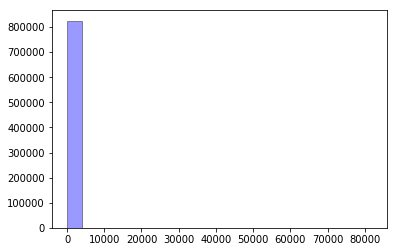

In [17]:
## Distribution of the number of newletters
result = S.sum(axis = 0)
result = np.array(np.matrix.tolist(result)[0])
sns.distplot(result, hist=True, kde=False, 
             bins=20, color = 'blue',
             hist_kws={'edgecolor':'black'})

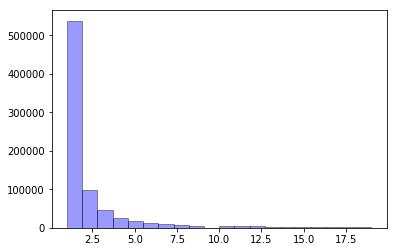

In [18]:
## By looking more closely arround 1 we have:
sns.distplot(result[np.where(result < 20)[0]], hist=True, kde=False, 
             bins=20, color = 'blue',
             hist_kws={'edgecolor':'black'})

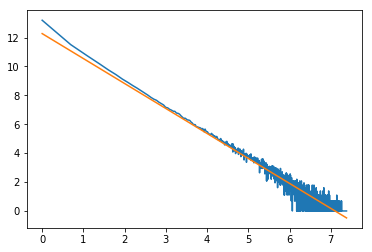

In [19]:
## This distribution looks like a fat-tail power law distribution, let's check this.
a = sorted(result)
b = np.array([len(list(group)) for key, group in groupby(a)])
abc = np.array([np.log(i+1) for i in range(len(b))])

abc = np.array([np.log(i+1) for i in range(len(b))])
regr = LinearRegression()
regr.fit(abc.reshape(-1,1), (np.log(b)).reshape(-1,1))

sns.lineplot(x = abc,y = np.log(b))
sns.lineplot(x = abc,y = regr.predict(abc.reshape(-1,1)).T[0])

In [20]:
k = -float(regr.coef_)
a = float(np.exp(regr.intercept_))
print(k)
print(a)

1.727288012808117
213485.34046980037


We effectively have a fat tail distribution with parameters $k = 1.73$ and $a = 213485$.

In [21]:
## Average number of newletters per gender :
resultGender = S.sum(axis = 1)

In [22]:
resultGender = np.array(np.matrix.tolist(np.matrix.transpose(resultGender))[0])
distribMale = resultGender[np.where(y == 1)[0]]
distribFemale = resultGender[np.where(y == 0)[0]]

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


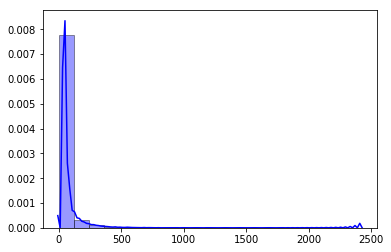

In [23]:
sns.distplot(distribMale, hist=True, kde=True, 
             bins=20, color = 'blue',
             hist_kws={'edgecolor':'black'})

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


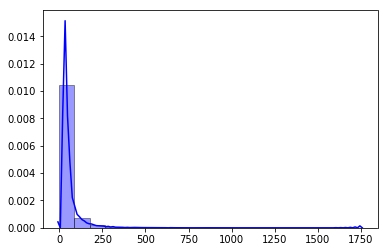

In [24]:
sns.distplot(distribFemale, hist=True, kde=True, 
             bins=20, color = 'blue',
             hist_kws={'edgecolor':'black'})

In [25]:
print(np.mean(distribMale))
print(np.mean(distribFemale))

42.77699904148017
41.21934189672943


### Discussion

From our previous analysis, we can notice that :

- We have very sparse data, with many newletters and a low mean number of newletters adopted by invividual.
- The distribution of the number of individuals adopting each newletter is very skewed and follow a power law distribution, with many newletters adopted by very few people, but with the presence of newletters adopted by a very large audience. This distribution is encountered in many real-world examples, such as the number of citation by research article or the distribution of wealth.
- The behaviour of each gender is similar in terms of mean number of newletters adopted. However, the variance of the distribution is different, we could infer a weak classifier from the number of newletters adopted taking advantage of this difference in variance.
- From the previous point, we can make the approximation that deleting the least popular newletters would reduce the dimension of the features and limit the loss of information.
- As starting point, one could use the L-curve criterion on the distribution of the count distribution of the newletters, which should optimize the ratio between loss of information (we discard newletters that carry little information compared to the remaining newletters) and reduction of the complexity:

$f(x) = ax^{-k}$, we want to minimize $g(x) = x^{2} + f^{2}(x)$, after computation we have $x_{min} = (ka^{2})^{\frac{1}{2k + 2}} = 99.45$.

This criterion suggest to discard all the newletters that are adopted by less than $100$ individuals.

Of course, we could use other methods for dimensionality reduction in an unsupervised configuration such as PCA, t-SNE or SVD. However these methods have the disadvantage of losing interpretability.

In [26]:
xmin = (k*a*a)**(1/(2*k+2))
print(xmin)

99.45057488031195


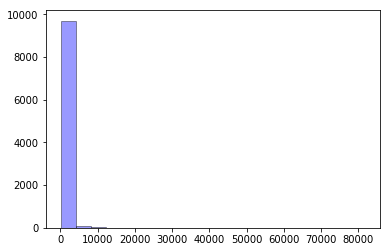

In [27]:
sns.distplot(result[np.where(result > 99)[0]], hist=True, kde=False, 
             bins=20, color = 'blue',
             hist_kws={'edgecolor':'black'})

In [28]:
len(np.where(result > 99)[0])

9859

Our criterion select a "vocabulary" of the $9859$ most encountered newletters. Let's reduce the matrix S:

In [29]:
Sreduced = S[:,np.where(result > 99)[0]]

In [30]:
Sreduced.shape

(203946, 9859)

### Logistic Lasso
The use of classifier with sparse selection of features such as the logistic regression with Lasso is expected to be convenient:

$p(C = 1 | x) = \frac{1}{1+e^{-\beta^{T}x}}$ where C is the class (Male of Female), $x = [1,x_{1}, ..., x_{m}]$ is the one-hot vector of newletters and $\beta = [\beta_{0}, \beta_{1}, ... \beta_{m}]$ are the weight coefficients.

The loss function will be $\mathcal{L}(\beta | \mathcal{D}) = \sum\limits_{i = 1}^{p} C^{i}log(p(C = 1 | x^{i})) + (1-C^{i})log(1-p(C = 1 | x^{i})) + \lambda||\beta||_{1}$ where $\lambda$ is the regularization hyperparameter that will be fitted by cross validation, and whose generalized score will be assessed by nested cross-validation.

We carry out a nested cross validation in order to select the parameter $C = \frac{1}{\lambda}$ representing the inverse of the strengh of the regularization. 
The gridsearch cv already implement a hyperparameter selection via cross-validation where stratified 3-folds are used (the proportion of the classes "Male" and "Female" are preserved in the folds). The classes are relatively balanced ($56\%$ of male, $44\%$ of female) so the mean accuracy score could be used for model evaluation.

In [31]:
## Model selection and fitting on the whole dataset through cross-validation.
C_candidates = dict(C=np.logspace(-2, 1, 10))
clf = GridSearchCV(estimator=LogisticRegression(penalty = "l1"), param_grid=C_candidates)
clf.fit(Sreduced, y)
clf.best_estimator_.C

0.21544346900318834

In [32]:
## Mean accuracy score of the test sets of the best model
clf.best_score_

0.8038206191835093

The goal of this model is to select a potentially small subset of newletters that are the most relevant for predicting gender. Let's compute the number of newletters selected by our model.

In [33]:
len(np.nonzero(clf.best_estimator_.coef_[0])[0])

4435

When we do not use Sreduced but directly the raw data, we can notice that $5488$ newletters are selected over $825409$.

When we use the reduced matrix we obtain $4435$ newletters out of $9859$.

The previous score is biased in the sense that it represents the best score one can attain with the data available, and $\lambda$ has been selected to maximize this score. To assess the potential generalized error we can perform a nested cross validation, where the outer loop assess the error of a model fitted and selected by cross-validation in the inner loop.

In [34]:
cross_val_score(clf, Sreduced, y)

array([0.83512054, 0.80578683, 0.7704947 ])

We have an estimator of the generalized accuracy of the model of roughly $80\%$ with $4435$ newletters, we obtain the same generalized score with $5488$ newletters performing the lasso directly on the raw data.

### Naive bayes classifier
From a probabilistic view, we try to model $P(C | X_{1}, ..., X_{m})$ from the data. If we had an infinite amount of data we could directly infer the distribution using contingency tables, which is inconceivable here. We hence need to put some structure on the conditional independances between the random variables representing the features. The simplest one is to consider independance of the features given the gender:
$P(X_{1}, ..., X_{m} | C) = \prod\limits_{i = 1}^{m}P(X_{i} | C)$.

Given $P(C | X_{1}, ..., X_{m}) \propto P(C)\prod\limits_{i = 1}^{m}P(X_{i} | C)$ the MAP estimate of $C$ is the one maximizing the previous quantity (which is not a probability).

We can simply model $P(X_{i} | C)$ by a bernouilli distribution with parameter $\hat{p_{i}} = \frac{\#newletter_{i,c}}{\#C}$ which is the proportion of occurence of the newletter $i$ in each gender.

In [35]:
alpha_candidates = dict(alpha=np.logspace(-1, 1, 10))
clfBayes = GridSearchCV(estimator=BernoulliNB(), param_grid=alpha_candidates)
clfBayes.fit(Sreduced, y)
clfBayes.best_estimator_.alpha

0.46415888336127786

In [36]:
clfBayes.best_score_

0.7769997940631344

In [37]:
cross_val_score(clfBayes, Sreduced, y)

array([0.78575526, 0.79578418, 0.74773834])

Here we obtain roughly $77.6\%$ of generalized accuracy.

### Support Vector Machine

#### Linear Kernel

In [38]:
## Model selection and fitting on the whole dataset through cross-validation.
C_candidates = dict(C=np.logspace(-1, 0, 5))
clfSVM = GridSearchCV(estimator=LinearSVC(penalty = 'l1', dual = False), param_grid=C_candidates)
clfSVM.fit(Sreduced, y)
clfSVM.best_estimator_.C

0.1

In [39]:
clfSVM.best_score_

0.7963578594333794

In [40]:
## Number of features kept by the algorithm
len(np.nonzero(clfSVM.best_estimator_.coef_[0])[0])

6548

In [41]:
cross_val_score(clfSVM, Sreduced, y)

/home/pierre/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/pierre/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/pierre/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/pierre/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of rely

array([0.82675081, 0.79907917, 0.76324267])

We obtain $79.6\%$ of mean generalized accuracy.

## Conclusion

As a first step we explored the data and noticed we were in a classification task with very sparse binary inputs. From this situation, we performed feature dimensionality reduction as a preprocessing step. To do this, we deleted the least encountered newletters using the L-curve criterion on the distribution of the count of newletters by popularity, which follows a power law distribution. We, then, fitted a Naive Bayes classifier, a linear SVM and finally a Logisttic regression, with Lasso regularization to further select important features. We obtained estimators of the generalized error of roughly $80\%$ of accuracy.
We should also fit other SVM models with other kernels and random forest or gradient boosting to have a more comprehensive list of potential model.

In our situation feature selection is important, if one cares about the interpretability of the features (understand which newletters are more responsible for gender classification than others), then our approach, or a statistical approach based on feature selection via chi-square tests for instance can be used, otherwise, we can perform SVD, PCA or t-sne.